# 에너지 빅데이터 활용 데이터 사이언스 콘테스트
전력수요예측 대회
- **작성일 : 2019-10-21**
- **팀명 : TEAM-EDA**
- **작성자 : 김현우, 이해중**

## 목적(Objectives)
본 대회에서는, 기존 전력 사용 기록과 기상 데이터 등 공공 데이터를 이용하여, 각 가정 및 회사의 시간별, 일별, 월별 전력 사용량을 예측합니다. 2018년 7월1일부터 2018년 11월 30일까지의 에너지 사용량을 예측합니다. 보다 정확히는 다음을 예측합니다.

 
- 2018년 7월 1일 00시부터 24시까지, 24시간, ‘시간당 전력사용량’ (24게)

- 2018년 7월 1일부터 7월10일까지, 10일간, ‘일간 전력사용량’ (10개)

- 2018년 7월부터 11월까지, 5개월간, ‘월간 전력사용량’ (5개)

 
즉 각 세대(또는 상가)당 39개(24개,10개,5개)의 값을 예측해야 합니다.

In [52]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [16, 8]

## 데이터(Data)

> **과거 16-18년도 당시 인천 기상 예측 데이터 제공**

1. **train.csv**
    - 국내(인천지역) 특정 지역의 모 아파트 및 모 상가의 전력사용량. (1300호)  
    - 2016년 7월 26일 11시 ~ 2018년 6월 30일 24시까지 시간 당 전력사용량  

2. **test.csv**
    - 국내(인천지역) 특정 지역의 모 아파트 및 모 상가의 전력사용량. (200호)  
    - 2017년 7월 1일 00시 ~ 2018년 6월 30일 24시까지 시간 당 전력사용량
    - train의 세대와 다른 세대

3. **submission.csv**
    - test셋에 제시된 세대(상가)에 대한 예측값들을 제출하는 포맷
    
4. **weather.csv**
    - 2016년 7월 26일 11시 ~ 2018년 6월 30일 24시까지 시간 당 날씨

In [3]:
path = 'C:/Users/choco/Desktop/Github/Dacon/Energy Bigdata Utilization/'
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (14,5)
plt.rcParams['axes.grid'] = True 

train_data = pd.read_csv(path+'input/train.csv')
test_data = pd.read_csv(path+'input/test.csv')
submission_data = pd.read_csv(path+'input/submission_1002.csv', index_col = 'meter_id').astype('float')

# 기상 데이터 불러오기
weather_data_hour = pd.read_csv(path+'input/인천_시간별__기상자료(16-18)_축소__7월1일.csv', engine = 'python')
weather_data_hour['일시'] = pd.to_datetime(weather_data_hour.일시)
weather_data_hour = weather_data_hour.set_index('일시')

weather_data_day = pd.read_csv(path+'input/인천_일별_기상자료(16-18)_축소.csv', engine = 'python')
weather_data_day['일시'] = pd.to_datetime(weather_data_day.일시)
weather_data_day = weather_data_day.set_index('일시')

In [4]:
print('train shape : ',train_data.shape)
print('test shape : ',test_data.shape)
print('submission shape : ',submission_data.shape)
print("weather_data_hour :", weather_data_hour.shape)
print("weather_data_day :", weather_data_day.shape)

train shape :  (16909, 1301)
test shape :  (8760, 201)
submission shape :  (200, 39)
weather_data_hour : (17088, 8)
weather_data_day : (721, 4)


In [5]:
train_data.head()

,Time,X692,X1272,X553,X1299,X4,X598,X1003,X1010,X1216,...,X1164,X656,X1287,X324,X767,X1271,X1288,X58,X1033,X1163
0,2016-07-26 11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-26 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-26 13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26 14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-26 15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


head를 찍어보면 모두 결측치를 가지고 있음. 

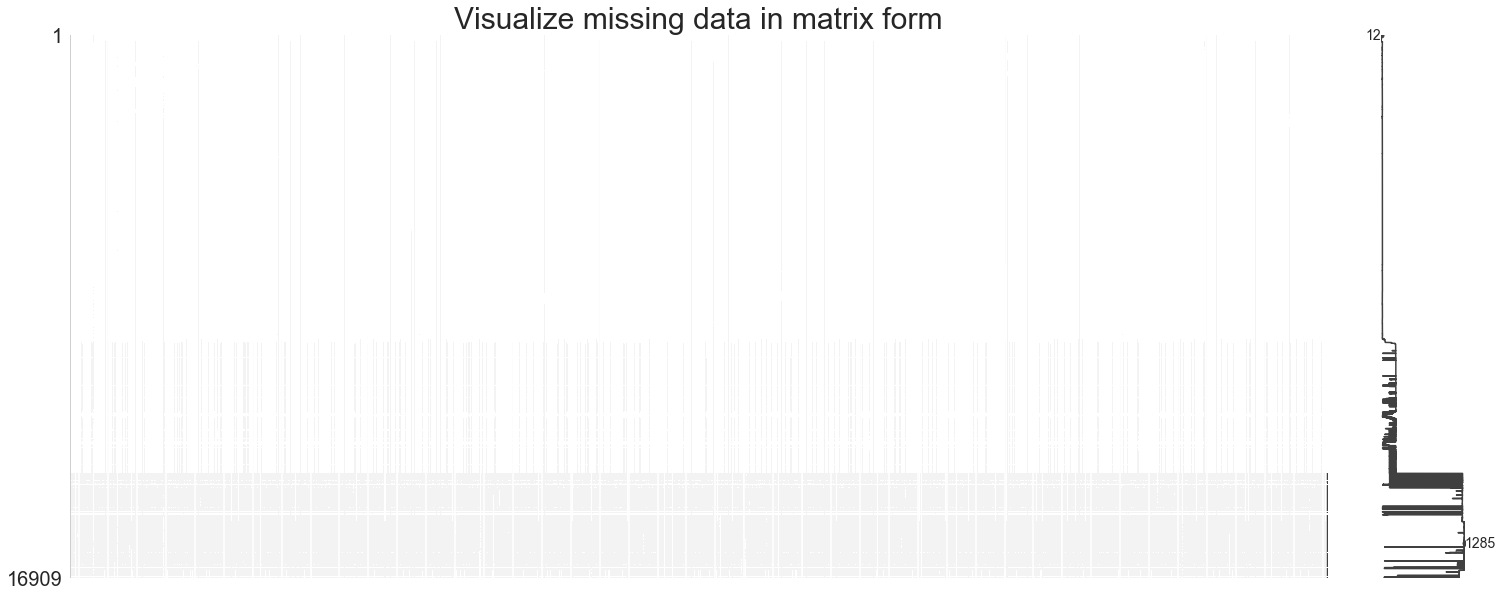

In [8]:
import missingno as msno

# 매트리스 형태로 누락데이터를 시각화하는 명령
# 누락 데이터는 흰색
# 가장 오른쪽에 있는 것은 스파크라인(spark line) : 각 행의 데이터 완성도를 표현한다.
msno.matrix(train_data)
plt.title("Visualize missing data in matrix form", fontsize=30)
plt.show()

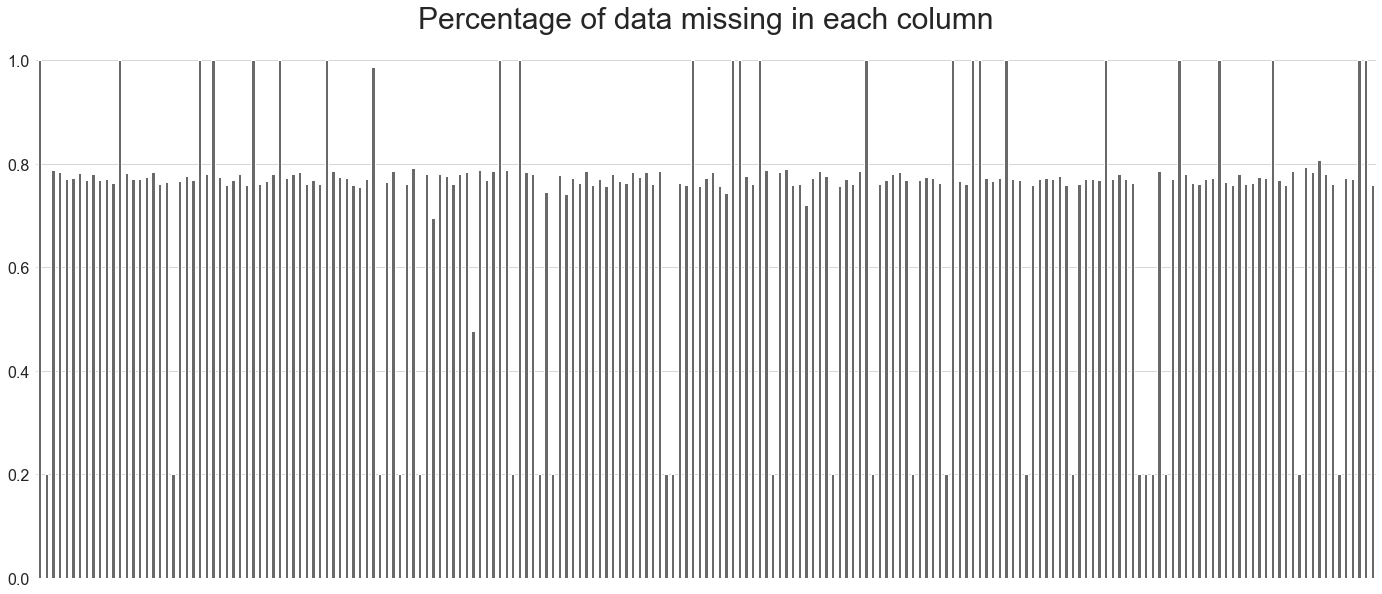

In [9]:
# 각 열의 누락데이터가 얼마나 존재하는지에 대해서만 시각화
msno.bar(test_data)
plt.title("Percentage of data missing in each column", fontsize=30)
plt.show()

Train과 Test의 결과를 보면, 각 meter_id마다 결측치가 많은 것을 확인할 수 있음. 데이터가 어떤 형식으로 결측치를 가지는지 확인하기 위해서 meter_id X692와 X4에 대해서 결측치의 패턴을 살펴보도록 하겠음. 

In [49]:
X692 = train_data[['Time','X692']].reset_index(drop=True).rename(columns={'X692':'y'})
X4 = train_data[['Time','X4']].reset_index(drop=True).rename(columns={'X4':'y'})
X692['meter_id'] = 'X692'; X4['meter_id'] = 'X4'
Missing = pd.concat([X692,X4], axis=0)
Missing = Missing.sort_values(by='Time')
Missing['Missing'] = 0
Missing.loc[Missing['y'].isnull(), 'Missing'] = 1

del X692, X4

In [50]:
Missing.groupby(['meter_id'])['Missing'].sum()

meter_id
X4      16909
X692    13845
Name: Missing, dtype: int64

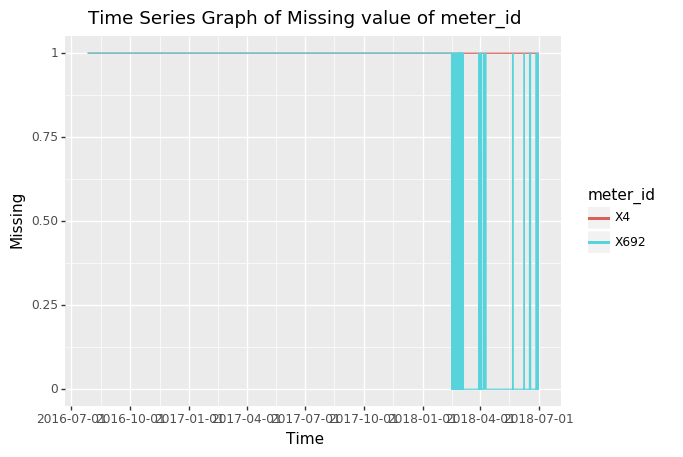

<ggplot: (112407401676)>

In [53]:
from plotnine import *

Missing['Time'] = pd.to_datetime(Missing['Time'])
(ggplot(Missing , aes(x='Time', y='Missing', group='meter_id', color='meter_id')) \
    + geom_line() \
    + ggtitle('Time Series Graph of Missing value of meter_id'))

In [32]:
train_data.T.head()

,0,1,2,3,4,5,6,7,8,9,...,16899,16900,16901,16902,16903,16904,16905,16906,16907,16908
Time,2016-07-26 11:00,2016-07-26 12:00,2016-07-26 13:00,2016-07-26 14:00,2016-07-26 15:00,2016-07-26 16:00,2016-07-26 17:00,2016-07-26 18:00,2016-07-26 19:00,2016-07-26 20:00,...,2018-06-30 14:00,2018-06-30 15:00,2018-06-30 16:00,2018-06-30 17:00,2018-06-30 18:00,2018-06-30 19:00,2018-06-30 20:00,2018-06-30 21:00,2018-06-30 22:00,2018-06-30 23:00
X692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.275,0.328,0.498,0.396,0.331,0.271,0.341,0.535,0.379,0.388
X1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.688,0.484,0.543,0.631,0.666,0.754,0.827,0.516,0.494,0.482
X553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.45,0.454,0.468,0.397,0.415,0.327,0.478,0.558,0.605,0.651
X1299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.159,0.18,0.171,0.17,0.312,0.468,0.356,0.496,0.32,0.284


위의 line plot을 통해 확인할 수 있는 점은, 전력량은 meter기 별로 특정시점부터 존재하고 그 시점은 모두 다름. x4와 같이 모두가 결측치인 경우도 있음. 

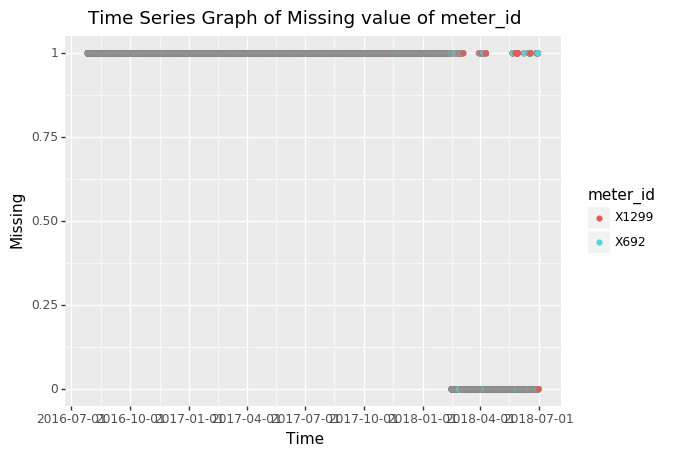

<ggplot: (112407777102)>

In [54]:
X692 = train_data[['Time','X692']].reset_index(drop=True).rename(columns={'X692':'y'})
X1299 = train_data[['Time','X1299']].reset_index(drop=True).rename(columns={'X1299':'y'})
X692['meter_id'] = 'X692'; X1299['meter_id'] = 'X1299'
Missing = pd.concat([X692,X1299], axis=0)
Missing = Missing.sort_values(by='Time')
Missing['Missing'] = 0
Missing.loc[Missing['y'].isnull(), 'Missing'] = 1

del X692, X1299

Missing['Time'] = pd.to_datetime(Missing['Time'])
(ggplot(Missing , aes(x='Time', y='Missing', group='meter_id', color='meter_id')) \
    + geom_point() \
    + ggtitle('Time Series Graph of Missing value of meter_id'))

X1299와 X692의 point plot을 보면 결측치가 없다가 생기는 구간이 있음. 이를 좀 더 자세히 보면, 아래의 X1299같은 경우에는 22시에 값을 가지고 23시에 결측치를 가지는 경향을 보임. 

In [60]:
Missing['next_Missing'] = Missing.groupby(['meter_id'])['Missing'].shift(-1)
Missing[(Missing['meter_id']=='X1299') & (Missing['Missing']==0) & (Missing['next_Missing']== 1)].head()

,Time,y,meter_id,Missing,next_Missing
13667,2018-02-15 22:00:00,0.515,X1299,0,1.0
13691,2018-02-16 22:00:00,0.570,X1299,0,1.0
13715,2018-02-17 22:00:00,0.175,X1299,0,1.0
13739,2018-02-18 22:00:00,0.536,X1299,0,1.0
13763,2018-02-19 22:00:00,1.242,X1299,0,1.0


이 구간을 더 자세히 보면, 결측치를 가지기 전에 값(1.242)이 이전보다 좀 큰 경향이 있음. 

In [64]:
Missing[(Missing['meter_id']=='X1299')].iloc[13760:13766]

,Time,y,meter_id,Missing,next_Missing
13760,2018-02-19 19:00:00,0.098,X1299,0,0.0
13761,2018-02-19 20:00:00,0.112,X1299,0,0.0
13762,2018-02-19 21:00:00,0.764,X1299,0,0.0
13763,2018-02-19 22:00:00,1.242,X1299,0,1.0
13764,2018-02-19 23:00:00,NaN,X1299,1,0.0
13765,2018-02-20 00:00:00,0.534,X1299,0,0.0


In [11]:
sub = pd.read_csv("./input/submission_1002.csv")
sub

,meter_id,X2018_7_1_1h,X2018_7_1_2h,X2018_7_1_3h,X2018_7_1_4h,X2018_7_1_5h,X2018_7_1_6h,X2018_7_1_7h,X2018_7_1_8h,X2018_7_1_9h,...,X2018_7_6_d,X2018_7_7_d,X2018_7_8_d,X2018_7_9_d,X2018_7_10_d,X2018_7_m,X2018_8_m,X2018_9_m,X2018_10_m,X2018_11_m
0,X5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,X7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,X10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,X16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,X18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,X468,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,X470,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,X472,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,X473,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train과 test의 간격은 동일하고, submission은 test 이후의 기간만을 포함하고 있음. 
- train을 사용하지 않고 모델을 예측가능함. 
- train을 어떻게 활용해야할지 고민해야함. 